In [1]:
from joblib import Parallel, delayed
import time
import numpy as np
import pandas as pd
import scipy.sparse as sp

def process_single_burst(iBurst, burst_starts, burst_ends, n_timebins, sparse_spike_counts, head, tail):
    burst_start_bin = burst_starts[iBurst]
    burst_end_bin = burst_ends[iBurst]
    burst_width = (burst_end_bin - burst_start_bin) + 1  # in bins
    total_bins_expected = head + burst_width + tail

    if burst_start_bin < head:
        start_bin_index = 0
    else:
        start_bin_index = burst_start_bin - head

    end_bin_index = burst_end_bin + tail + 1
    if end_bin_index > n_timebins:
        end_bin_index = n_timebins

    n_bins_in_window = end_bin_index - start_bin_index

    if n_bins_in_window <= 0 or n_bins_in_window != total_bins_expected:
        # Return None to indicate failure for this burst.
        return None, iBurst

    # Convert only the required slice from sparse to dense.
    frame = sparse_spike_counts[:, start_bin_index:end_bin_index].toarray().astype(np.uint16)
    return frame, iBurst

# Then modify compute_frames_from_sparse to use parallel processing:
def compute_frames_from_sparse_parallel(npz_filename, burst_info_csv, head=0, tail=0, bin_scaling=1, n_jobs=2):
    print("Loading sparse spike count matrix from NPZ...")
    sparse_spike_counts = sp.load_npz(npz_filename)
    n_neurons, n_timebins = sparse_spike_counts.shape
    print(f"Matrix loaded: {n_neurons} neurons, {n_timebins} timebins (each 10 ms).")
    
    print("Loading burst info from CSV...")
    burst_info_df = pd.read_csv(burst_info_csv)
    burst_starts = ((burst_info_df['startBin#'].to_numpy() - 1) / bin_scaling).astype(int)
    burst_ends   = ((burst_info_df['endBin#'].to_numpy() - 1) / bin_scaling).astype(int)
    n_bursts = len(burst_starts)
    print(f"Found {n_bursts} bursts (after scaling with factor {bin_scaling}).")
    
    t0 = time.time()
    
    # Process all bursts in parallel.
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_single_burst)(iBurst, burst_starts, burst_ends, n_timebins, sparse_spike_counts, head, tail)
        for iBurst in range(n_bursts)
    )
    
    frames = []
    valid_indices = []
    for frame, iBurst in results:
        if frame is not None:
            frames.append(frame)
            valid_indices.append(iBurst)
    
    print(f"Processed {len(valid_indices)} valid bursts out of {n_bursts} in {time.time() - t0:.1f}s")
    return frames, valid_indices


In [2]:
from joblib import dump, load

def save_frames_joblib(frames, filename="burst_frames.joblib"):
    """Saves frames and valid indices using joblib."""
    data = {"frames": frames}
    dump(data, filename)
    print(f"Frames saved to {filename}.")

def load_frames_joblib(filename="burst_frames.joblib"):
    """Loads frames and valid indices using joblib."""
    data = load(filename)
    return data["frames"]

In [3]:
from matplotlib import pyplot as plt

def visualize_frame(frame, title="Burst Frame"):
    """
    Visualizes a burst frame as a heatmap.
    
    Parameters:
      frame (2D np.array): A 2D array of spike counts with shape (n_neurons, n_bins).
      title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 8))
    # Display the frame as an image.
    # 'aspect' set to 'auto' lets matplotlib choose the best fit.
    # 'origin' set to 'upper' displays the first row at the top.
    # plt.imshow(frame, aspect='auto', cmap="viridis", origin="upper")
    plt.imshow(frame.T, aspect='auto', cmap="viridis", origin="upper")
    plt.colorbar(label="Spike Count")
    plt.xlabel("Neuron Index")
    plt.ylabel("Time Bins")
    plt.title(title)
    plt.show()


In [4]:
import os

if __name__ == '__main__':
    npz_filename = '/DATA/hdhanu/GNN/Burst_Data/spike_matrix_sparse.npz'
    burst_info_csv = os.path.join('/DATA/hdhanu/GNN/Burst_Data/output/', 'allBinnedBurstInfo.csv')
    frames, valid_indices = compute_frames_from_sparse_parallel(npz_filename, burst_info_csv, head=0, tail=0, bin_scaling=1, n_jobs=2)
    # visualize_frame(frames[0], title="Burst Frame[0]")
    save_frames_joblib(frames, filename="burst_frames.joblib")

Loading sparse spike count matrix from NPZ...
Matrix loaded: 10000 neurons, 6000000 timebins (each 10 ms).
Loading burst info from CSV...
Found 9164 bursts (after scaling with factor 1).
Processed 9164 valid bursts out of 9164 in 2953.9s
Frames saved to burst_frames.joblib.


In [6]:
from ipywidgets import interact

def interactive_visualize(burst_index):
    if 0 <= burst_index < len(frames):
        visualize_frame(frames[burst_index], title=f"Burst Frame {burst_index}")
    else:
        print("Burst index out of range!")

interact(interactive_visualize, burst_index=(0, len(frames)-1))


interactive(children=(IntSlider(value=4581, description='burst_index', max=9163), Output()), _dom_classes=('wi…

<function __main__.interactive_visualize(burst_index)>

In [ ]:
# def get_burst_origin_xyn(frame, xlocs, ylocs):
#     """
#     Given a burst frame (2D array: n_neurons x n_bins) of spike counts,
#     and arrays xlocs and ylocs for neuron locations,
#     compute the burst origin as follows:
#       1. Sum the spike counts in each bin to identify the bin with the maximum total spikes.
#       2. In that bin, select the neuron with the highest spike count.
    
#     Returns:
#       x: x-coordinate of the chosen neuron.
#       y: y-coordinate.
#       neuron_id: index (zero-based) of the neuron.
#       origin_bin: index (zero-based) of the bin in the frame where the burst origin occurs.
#     """
#     # Sum spike counts across neurons for each bin.
#     bin_sums = frame.sum(axis=0)
#     origin_bin = int(np.argmax(bin_sums))
    
#     # For the bin with maximum spikes, find the neuron with the highest count.
#     neuron_counts = frame[:, origin_bin]
#     neuron_id = int(np.argmax(neuron_counts))
    
#     x = xlocs[neuron_id]
#     y = ylocs[neuron_id]
#     return x, y, neuron_id, origin_bin

# def compute_burst_origins(frames, xlocs, ylocs):
#     """
#     For each burst frame in frames, compute the burst origin using get_burst_origin_xyn.
    
#     Returns:
#       origins: List of tuples (x, y, neuron_id, origin_bin) for each burst.
#     """
#     origins = []
#     for i, frame in enumerate(frames):
#         try:
#             x, y, neuron_id, origin_bin = get_burst_origin_xyn(frame, xlocs, ylocs)
#             origins.append((x, y, neuron_id, origin_bin))
#         except Exception as e:
#             print(f"Warning: Burst {i+1} origin computation failed: {e}")
#             origins.append((np.nan, np.nan, np.nan, np.nan))
#     return origins

In [ ]:
# # Load neuron locations from HDF5.
# import csv
# import os 

# print("Loading neuron locations from csv file...")
# df_locs = pd.read_csv('/home/NETID/hdhanu/GNN/node_attributes.csv')
# xlocs = df_locs['x']
# ylocs = df_locs['y']
# print(f"Loaded locations for {len(xlocs)} neurons.")

# # Compute burst origins.
# origins = compute_burst_origins(frames, xlocs, ylocs)
# output_csv = os.path.join('/home/NETID/hdhanu/GNN/Burst_Data/output/', 'allBurstOrigin_new.csv')
# # Save burst origins to CSV.
# with open(output_csv, 'w', newline='') as csvfile:
#     csv_writer = csv.writer(csvfile)
#     csv_writer.writerow(['x', 'y', 'neuronID', 'origin_bin'])
#     for origin in origins:
#         csv_writer.writerow(origin)
# print(f"Burst origins saved to {output_csv}")

Loading neuron locations from csv file...
Loaded locations for 9999 neurons.
Burst origins saved to /home/NETID/hdhanu/GNN/Burst_Data/output/allBurstOrigin_new.csv


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import csv

def compute_exact_burst_origin(frame, xlocs, ylocs, global_start, threshold=2):
    """
    Compute the burst origin using the brightest pixel (exact neuron) selection method.
    
    For a given burst frame (2D array: n_neurons x n_bins) and a known global start bin (from the CSV),
    this function iterates over the columns (time bins) from the beginning and finds the first
    column where the maximum spike count is greater than or equal to 'threshold'.
    
    It then selects the first neuron (lowest index) that attains this maximum in that column.
    The function returns the (x, y) coordinates from xlocs and ylocs, the exact neuron ID, and
    the global bin index of the burst origin (global_start + local column index).
    
    Parameters:
      frame (np.array): 2D array of spike counts (n_neurons x n_bins).
      xlocs (np.array): 1D array of neuron x coordinates.
      ylocs (np.array): 1D array of neuron y coordinates.
      global_start (int): The global bin index corresponding to column 0 of this burst frame.
      threshold (int): Minimum spike count required in a bin to be considered.
      
    Returns:
      A tuple (x, y, neuronID, global_origin_bin) where:
        - x: x coordinate (float) of the selected neuron.
        - y: y coordinate (float) of the selected neuron.
        - neuronID: The exact neuron index (int) selected as burst origin.
        - global_origin_bin: The global bin index = global_start + local bin index.
      If no column meets the threshold, returns None.
    """
    n_neurons, n_bins = frame.shape
    for b in range(n_bins):
        col = frame[:, b]
        max_val = np.max(col)
        if max_val >= threshold:
            indices = np.where(col == max_val)[0]
            # Select the first neuron with maximum count
            chosen_neuron = indices[0]
            x = xlocs[chosen_neuron]
            y = ylocs[chosen_neuron]
            global_origin_bin = global_start + b
            return x, y, int(chosen_neuron), global_origin_bin
    return None

def visualize_burst_origin_exact(frame, xlocs, ylocs, global_start, threshold=2, title="Burst Origin Verification"):
    """
    Visualizes a burst frame as a heatmap with an overlaid burst origin marker.
    
    The burst origin is computed using compute_exact_burst_origin with the given global_start.
    The visualization reshapes the selected column (assumed to have length n_neurons) into a 100x100
    matrix (assuming neurons are arranged in a 100x100 grid).
    
    Parameters:
      frame (np.array): 2D array of spike counts (n_neurons x n_bins) for the burst.
      xlocs (np.array): 1D array of neuron x coordinates.
      ylocs (np.array): 1D array of neuron y coordinates.
      global_start (int): The global bin number corresponding to the first column of frame.
      threshold (int): Spike threshold.
      title (str): Plot title.
    """
    origin_info = compute_exact_burst_origin(frame, xlocs, ylocs, global_start, threshold)
    if origin_info is None:
        print("No column in the burst frame reached the threshold.")
        return
    origin_x, origin_y, neuron_id, global_origin_bin = origin_info
    print(f"Selected local bin: {global_origin_bin - global_start} (global bin: {global_origin_bin})")
    print(f"Burst origin neuron: ID {neuron_id}, Coordinates: ({origin_x}, {origin_y})")
    
    # For visualization assume neurons are arranged as a 100x100 grid.
    try:
        img = np.reshape(frame[:, global_origin_bin - global_start], (100, 100), order='F').T
    except Exception as e:
        print("Error reshaping the selected column:", e)
        img = frame[:, global_origin_bin - global_start].reshape(-1,1)
    
    plt.figure(figsize=(8,8))
    plt.imshow(img, cmap="viridis", origin="upper")
    plt.colorbar(label="Spike Count")
    plt.xlabel("Pixel X")
    plt.ylabel("Pixel Y")
    plt.title(f"{title}\nGlobal Origin Bin: {global_origin_bin}, NeuronID: {neuron_id}\nCoordinates: ({origin_x}, {origin_y})")
    # Overlay marker (optionally adding 1 for one-based centering)
    plt.plot(origin_x + 1, origin_y + 1, marker='p', markersize=15,
             markerfacecolor='red', markeredgecolor='red')
    plt.tight_layout()
    plt.show()

def compute_and_save_exact_burst_origins(frames, global_starts, xlocs, ylocs, output_csv, threshold=2):
    """
    Computes the burst origin for each burst frame using the exact neuron (brightest pixel)
    method and saves the results to a CSV file.
    
    Parameters:
      frames (list): List of burst frames (each a 2D numpy array).
      global_starts (list or np.array): Global start bin (from the CSV) for each burst frame.
      xlocs (np.array): 1D array of neuron x coordinates.
      ylocs (np.array): 1D array of neuron y coordinates.
      output_csv (str): Path to save the CSV file.
      threshold (int): Spike count threshold.
    
    The CSV will contain columns:
      x, y, neuronID, origin_bin
    where origin_bin is the global bin index.
    """
    with open(output_csv, "w", newline="") as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(["x", "y", "neuronID", "origin_bin"])
        for i, frame in enumerate(frames):
            global_start = global_starts[i]
            origin_info = compute_exact_burst_origin(frame, xlocs, ylocs, global_start, threshold)
            if origin_info is None:
                csv_writer.writerow([None, None, None, None])
            else:
                x, y, neuronID, global_origin_bin = origin_info
                csv_writer.writerow([x, y, neuronID, global_origin_bin])
    print(f"Burst origins saved to {output_csv}")



In [ ]:

# --- Example Usage ---
if __name__ == "__main__":
    # Load burst frames from your joblib file
    from joblib import load
    burst_data = load("/DATA/hdhanu/GNN/Burst_Data/burst_frames.joblib")
    frames = burst_data["frames"]
    
    # Load node attributes from CSV
    import pandas as pd
    node_df = pd.read_csv("/DATA/hdhanu/GNN/node_attributes.csv")
    # Ensure sorted by neuron id; assume column "id" is there.
    node_df = node_df.sort_values("id")
    xlocs = node_df["x"].to_numpy()
    ylocs = node_df["y"].to_numpy()
    
    # Load burst info CSV to get global start bins for each burst (assuming 0-based indexing)
    burst_info_df = pd.read_csv("/DATA/hdhanu/GNN/Burst_Data/output/allBinnedBurstInfo.csv")
    # Assume the column 'startBin#' exists and is 0-based already.
    global_starts = burst_info_df["startBin#"].to_numpy().astype(int)
    
    # Visualize an example burst (for example, burst 0)
    example_frame = frames[0]
    example_global_start = global_starts[0]
    

NameError: name 'visualize_burst_origin_exact' is not defined

Selected local bin: 0 (global bin: 958625)
Burst origin neuron: ID 4143, Coordinates: (43.0, 41.0)


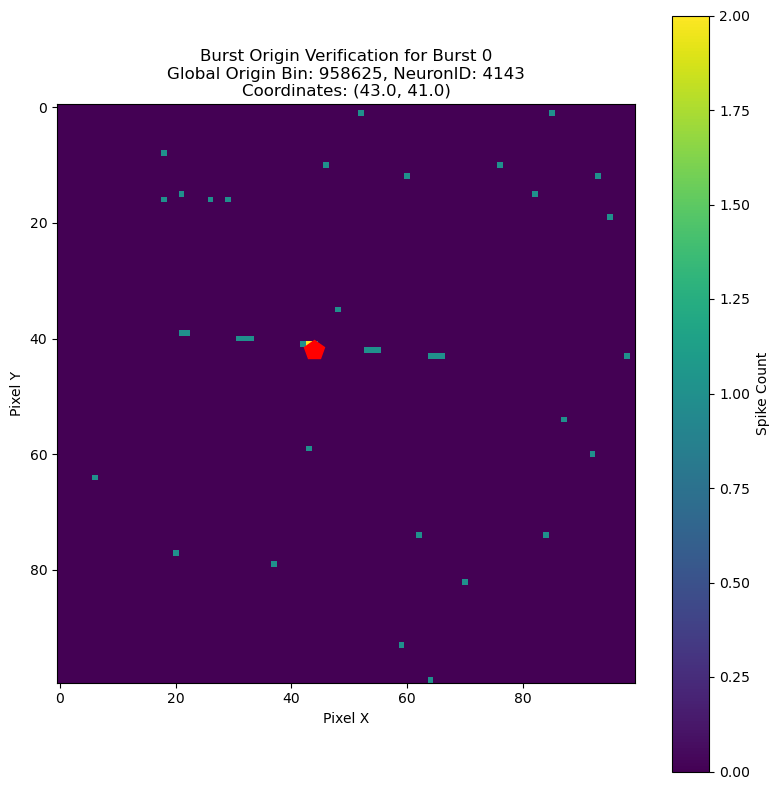

Burst origins saved to /DATA/hdhanu/GNN/Burst_Data/output/burst_origins_exact.csv


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_subsequent_bins(frame, start_bin, num_bins_to_show=10):
    """
    Visualizes a sequence of subsequent time bins from a burst frame.
    
    Parameters:
      frame (np.array): 2D array of spike counts with shape (n_neurons, n_bins).
      start_bin (int): The time bin index from which to start visualization.
      num_bins_to_show (int): Number of consecutive bins to visualize.
      
    Assumes that n_neurons is 10,000 so that it can be reshaped to a 100x100 grid.
    """
    n_neurons, n_bins = frame.shape
    grid_size = 100  # Assuming neurons are arranged as a 100x100 grid.
    
    # Create subplots.
    fig, axes = plt.subplots(1, num_bins_to_show, figsize=(4*num_bins_to_show, 4))
    
    for i in range(num_bins_to_show):
        bin_idx = start_bin + i
        if bin_idx >= n_bins:
            break
        # Extract the column for that bin (spike counts for each neuron).
        col_data = frame[:, bin_idx]
        try:
            # Reshape the column into a 100x100 image.
            img = np.reshape(col_data, (grid_size, grid_size), order='F').T
        except Exception as e:
            print(f"Error reshaping data for bin {bin_idx}: {e}")
            continue
        
        ax = axes[i] if num_bins_to_show > 1 else axes
        im = ax.imshow(img, cmap="viridis", origin="upper")
        ax.set_title(f"Bin {bin_idx}")
        ax.axis('off')
    
    # Add a single colorbar for all subplots.
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    plt.suptitle("Visualization of Subsequent Bins from Burst Frame")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

         # Now, visualize subsequent bins starting from the selected bin.


Selected local bin: 0 (global bin: 958625)
Burst origin neuron: ID 9332, Coordinates: (32.0, 93.0)


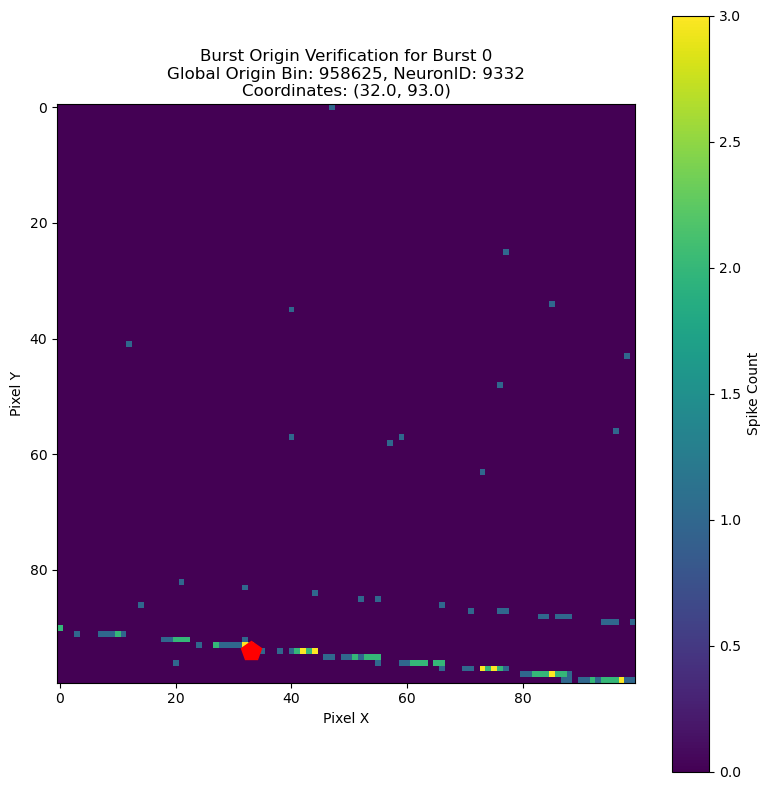

/tmp/ipykernel_15890/3736360679.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


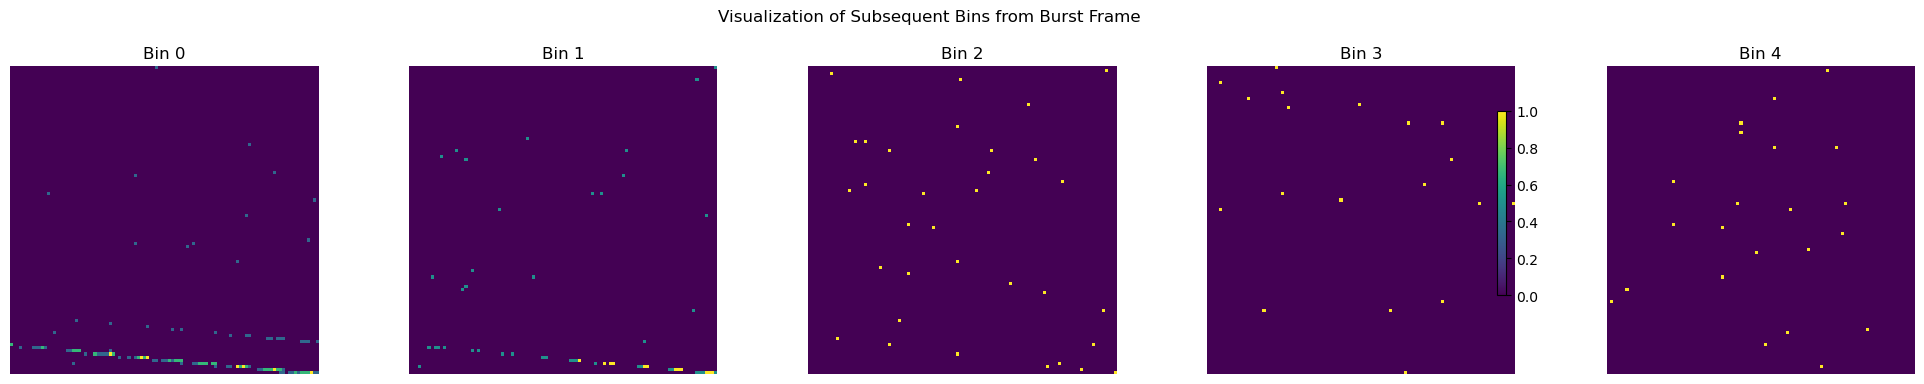

In [8]:
visualize_burst_origin_exact(frames[2], xlocs, ylocs, example_global_start, threshold=2,
                                  title="Burst Origin Verification for Burst 0")
visualize_subsequent_bins(frames[2], start_bin=0, num_bins_to_show=5)